In [1]:
import pandas as p
import numpy as n

# Load the dataset
d = p.read_csv('loan_data.csv')

# Display basic information about the dataset
print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             376 non-null    object 
 1   Married            381 non-null    object 
 2   Dependents         373 non-null    object 
 3   Education          381 non-null    object 
 4   Self_Employed      360 non-null    object 
 5   ApplicantIncome    381 non-null    int64  
 6   CoapplicantIncome  381 non-null    float64
 7   LoanAmount         381 non-null    int64  
 8   Loan_Amount_Term   370 non-null    float64
 9   Credit_History     351 non-null    float64
 10  Property_Area      381 non-null    object 
 11  Loan_Status        381 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 35.8+ KB
None


In [2]:
print(d.isnull().sum())

Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64


In [3]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

for col in categorical_columns:
    d[col].fillna(d[col].mode()[0], inplace=True)

In [4]:
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

for col in numerical_columns:
    d[col].fillna(d[col].median(), inplace=True)

In [5]:
print(d.isnull().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [6]:
# Convert 'Dependents' to numerical
d['Dependents'] = d['Dependents'].replace('3+', '3')
d['Dependents'] = p.to_numeric(d['Dependents'])

# Convert 'Loan_Status' to numerical
d['Loan_Status'] = d['Loan_Status'].map({'Y': 1, 'N': 0})

In [7]:
print(d.describe())
print(d.dtypes)

       Dependents  ApplicantIncome  CoapplicantIncome  LoanAmount  \
count  381.000000       381.000000         381.000000  381.000000   
mean     0.666667      3579.845144        1277.275381  104.986877   
std      0.987643      1419.813818        2340.818114   28.358464   
min      0.000000       150.000000           0.000000    9.000000   
25%      0.000000      2600.000000           0.000000   90.000000   
50%      0.000000      3333.000000         983.000000  110.000000   
75%      1.000000      4288.000000        2016.000000  127.000000   
max      3.000000      9703.000000       33837.000000  150.000000   

       Loan_Amount_Term  Credit_History  Loan_Status  
count        381.000000      381.000000   381.000000  
mean         341.417323        0.850394     0.711286  
std           67.625957        0.357154     0.453761  
min           12.000000        0.000000     0.000000  
25%          360.000000        1.000000     0.000000  
50%          360.000000        1.000000     1.00

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns (excluding 'Loan_Status' if it's your target variable)
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Initialize the OneHotEncoder
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform the categorical columns
encoded_cats = onehot.fit_transform(d[categorical_columns])

# Get the new column names
encoded_cols = onehot.get_feature_names(categorical_columns)

# Create a new dataframe with the encoded variables
encoded_df = p.DataFrame(encoded_cats, columns=encoded_cols, index=d.index)

# Concatenate the encoded dataframe with the original numerical columns
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
final_df = p.concat([d[numerical_columns], encoded_df, d['Loan_Status']], axis=1)

print(final_df.head())

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4583             1508.0         128             360.0   
1             3000                0.0          66             360.0   
2             2583             2358.0         120             360.0   
3             6000                0.0         141             360.0   
4             2333             1516.0          95             360.0   

   Credit_History  Gender_Female  Gender_Male  Married_No  Married_Yes  \
0             1.0            0.0          1.0         0.0          1.0   
1             1.0            0.0          1.0         0.0          1.0   
2             1.0            0.0          1.0         0.0          1.0   
3             1.0            0.0          1.0         1.0          0.0   
4             1.0            0.0          1.0         0.0          1.0   

   Dependents_0  ...  Dependents_2  Dependents_3  Education_Graduate  \
0           0.0  ...           0.0           0.0        

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
def detect_outliers(d, col):
    Q1 = d[col].quantile(0.25)
    Q3 = d[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = d[(d[col] < lower_bound) | (d[col] > upper_bound)]
    return outliers

# Check for outliers in each numerical column
for col in numerical_columns:
    outliers = detect_outliers(final_df, col)
    print(f"Outliers in {col}:")
    print(outliers[[col]])
    print(f"Number of outliers: {len(outliers)}")
    print("\n")

Outliers in ApplicantIncome:
     ApplicantIncome
14              7660
49              7100
72              7333
99              9323
153             9703
163             7200
228             6822
235             8750
240             7167
269             7250
275             8624
280             7142
290             7085
294             7740
Number of outliers: 14


Outliers in CoapplicantIncome:
     CoapplicantIncome
79              8980.0
110             5063.0
256            20000.0
319             5302.0
324             6666.0
364            33837.0
Number of outliers: 6


Outliers in LoanAmount:
     LoanAmount
8            17
65           25
84           25
91           30
168          30
350          26
357           9
Number of outliers: 7


Outliers in Loan_Amount_Term:
     Loan_Amount_Term
8               120.0
10              240.0
48              180.0
49               60.0
52              300.0
54              480.0
58              240.0
65              120.0
68         

In [11]:
def cap_outliers(d, col):
    Q1 = d[col].quantile(0.25)
    Q3 = d[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    d[col] = n.where(d[col] > upper_bound, upper_bound, 
                          n.where(d[col] < lower_bound, lower_bound, d[col]))
    return d

# Apply capping to numerical columns
for col in numerical_columns:
    final_df = cap_outliers(final_df, col)

# Check the results
print(final_df[numerical_columns].describe())

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       381.000000         381.000000  381.000000             381.0   
mean       3544.624672        1147.070656  105.195538             360.0   
std        1312.416395        1288.712177   27.773671               0.0   
min         150.000000           0.000000   34.500000             360.0   
25%        2600.000000           0.000000   90.000000             360.0   
50%        3333.000000         983.000000  110.000000             360.0   
75%        4288.000000        2016.000000  127.000000             360.0   
max        6820.000000        5040.000000  150.000000             360.0   

       Credit_History  
count           381.0  
mean              1.0  
std               0.0  
min               1.0  
25%               1.0  
50%               1.0  
75%               1.0  
max               1.0  


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = final_df.drop('Loan_Status', axis=1)
y = final_df['Loan_Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")

In [14]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
train_and_evaluate(lr_model, X_train_scaled, X_test_scaled, y_train, y_test)

# Linear Discriminant Analysis
lda_model = LinearDiscriminantAnalysis()
train_and_evaluate(lda_model, X_train_scaled, X_test_scaled, y_train, y_test)

# K-Nearest Neighbors
knn_model = KNeighborsClassifier()
train_and_evaluate(knn_model, X_train_scaled, X_test_scaled, y_train, y_test)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
train_and_evaluate(dt_model, X_train, X_test, y_train, y_test)

Model: LogisticRegression
Accuracy: 0.7403
Precision: 0.7224
Recall: 0.7403
F1 Score: 0.6608
Confusion Matrix:
[[ 2 19]
 [ 1 55]]


Model: LinearDiscriminantAnalysis
Accuracy: 0.7532
Precision: 0.7525
Recall: 0.7532
F1 Score: 0.6856
Confusion Matrix:
[[ 3 18]
 [ 1 55]]


Model: KNeighborsClassifier
Accuracy: 0.6234
Precision: 0.5601
Recall: 0.6234
F1 Score: 0.5860
Confusion Matrix:
[[ 2 19]
 [10 46]]


Model: DecisionTreeClassifier
Accuracy: 0.6753
Precision: 0.7001
Recall: 0.6753
F1 Score: 0.6850
Confusion Matrix:
[[11 10]
 [15 41]]




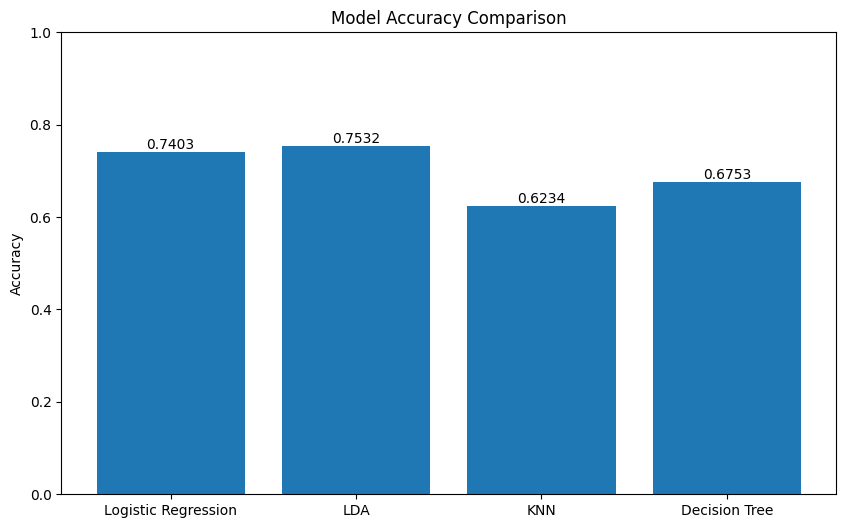

In [15]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'LDA', 'KNN', 'Decision Tree']
accuracies = [accuracy_score(y_test, model.predict(X_test_scaled if model.__class__.__name__ != 'DecisionTreeClassifier' else X_test)) for model in [lr_model, lda_model, knn_model, dt_model]]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score

def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"Model: {model.__class__.__name__}")
    print(f"Cross-validation scores: {scores}")
    print(f"Mean CV score: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    print("\n")

# Perform cross-validation for each model
cross_validate_model(lr_model, X_train_scaled, y_train)
cross_validate_model(lda_model, X_train_scaled, y_train)
cross_validate_model(knn_model, X_train_scaled, y_train)
cross_validate_model(dt_model, X_train, y_train)

Model: LogisticRegression
Cross-validation scores: [0.70491803 0.63934426 0.62295082 0.68852459 0.65      ]
Mean CV score: 0.6611
Standard deviation: 0.0307


Model: LinearDiscriminantAnalysis
Cross-validation scores: [0.70491803 0.63934426 0.60655738 0.67213115 0.65      ]
Mean CV score: 0.6546
Standard deviation: 0.0329


Model: KNeighborsClassifier
Cross-validation scores: [0.63934426 0.60655738 0.52459016 0.6557377  0.61666667]
Mean CV score: 0.6086
Standard deviation: 0.0454


Model: DecisionTreeClassifier
Cross-validation scores: [0.55737705 0.60655738 0.6557377  0.62295082 0.56666667]
Mean CV score: 0.6019
Standard deviation: 0.0363


